In [376]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/atp_data.csv",low_memory=False)
df.Date = df.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))


## Stratégie

il y a plusieurs stratégies envisageables, on peut :
1. Mettre en concurrence les cotes de plusieurs bookmakers sur un même pari de manière à être positif quel que soit le résultat
2. Pour un bookmaker donné, mettre en place une stratégie pour ne parier que sur les matchs avec un écart de cotes très élevés
3. Evaluer les performances des joueurs pour déterminer la probabilité de victoire par joueur, sans considération des cotes des bookmakers

Pour évaluer la qualité de ces différentes stratégies, nous réaliserons les étapes suivantes :
1. Données manquantes
1. Données erronées
1. Analyse

### 1. Données manquantes

In [378]:
df.isna().sum()

ATP              0
Location         0
Tournament       0
Date             0
Series           0
Court            0
Surface          0
Round            0
Best of         15
Winner           0
Loser            0
WRank            0
LRank            0
Wsets          302
Lsets          304
Comment          0
PSW           9186
PSL           9186
B365W         4061
B365L         4038
elo_winner       0
elo_loser        0
proba_elo        0
dtype: int64

Certaines cotes de paris sont absentes.

Les données sans cotes de paris restent utiles pour déterminer le profil par joueur, il est donc préférable de garder ces données.

### 2. Données erronées

<Axes: >

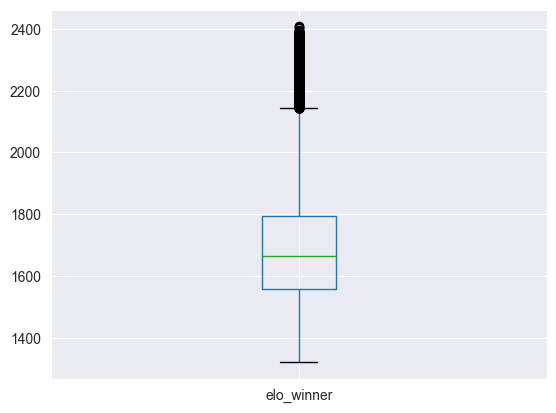

In [379]:
plt.figure()
df.boxplot(["elo_winner"])

### 3. Analyse

#### Stratégie 1 : Mettre en concurrence les cotes de plusieurs bookmakers sur un même pari de manière à être positif quel que soit le résultat

In [380]:
len(df.loc[(df["PSW"] > 2) & (df["B365L"] > 2)])
#df.loc[(df["PSW"] > 2) & (df["B365L"] > 2)]

22

Il y a 22 match (en 22 ans) ou les bookmakers divergent avec une cote supérieure à 2.  
Parier simultanément chez les 2 bookmakers garantit à 100% un gain qui serait la cote -2 pour le bookmaker gagnant.  
Le nombre de match dans cette situation est rare et encourage à jouer de grosse somme lorsque la situation survient.  
En pratique, cette méthode est à prendre avec prudence, on observe chez la FDJ notamment des pratiques douteurs consistant à annuler certains paris sportifs pour "erreur manifeste de cotes".  
https://www.communique-presse-jeu.com/ads/erreur-manifeste-de-cotes-fdj/  
Il serait catastrophique de miser une grosse somme et de se voir refuser le pari gagnant...

#### Stratégie 2 : Pour un bookmaker donné, mettre en place une stratégie pour ne parier que sur les matchs avec un écart de cotes très élevés

In [381]:
# pour cette stratégie on drop les na
df_filtered = df.dropna()

In [382]:
# Parier 1 sur tous les matchs en prenant toujours la plus petite cote : 
# = toutes les plus petites cotes pour les parties gagnées - nb parties / nb parties

print(100*(df_filtered.PSW[df_filtered.PSL>df_filtered.PSW].sum() - len(df_filtered)) /len(df_filtered))
print("Si on pariait 1 euros sur 100 matchs sur la cote la plus petite, on perdrait en moyenne 1.92€")


-2.1904385152765005
Si on pariait 1 euros sur 100 matchs sur la cote la plus petite, on perdrait en moyenne 1.92€


In [383]:
# Parier 1 sur tous les matchs en prenant toujours la plus petite cote avec un ecart de cote de 2 minimum: 
ecart = 2 
small_psw_sum = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW].sum()
total_games = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW] + df_filtered.PSL[df_filtered.PSW>ecart*df_filtered.PSL]
print(100*(small_psw_sum - len(total_games)) /len(total_games))
print("Si on pariait 1 euros sur 100 matchs sur la cote la plus petite avec un ecart de cote de 2, on perdrait en moyenne 0.84€")


-0.8407315340908976
Si on pariait 1 euros sur 100 matchs sur la cote la plus petite avec un ecart de cote de 2, on perdrait en moyenne 0.67€


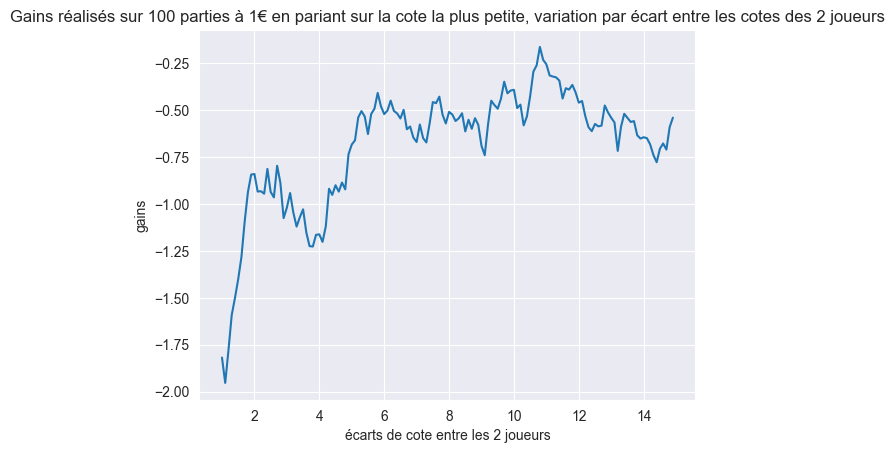

In [385]:
# graphe des petites cotes en faisant varier l'écart de cote 
ecarts = np.arange(1,15,0.1)
probas=[]
for ecart in ecarts:
    small_psw_sum = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW].sum()
    total_games = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW] + df_filtered.PSL[df_filtered.PSW>ecart*df_filtered.PSL]
    proba = 100*(small_psw_sum - len(total_games)) /len(total_games)
    probas.append(proba)

plt.plot(ecarts,probas)
plt.title("Gains réalisés sur 100 parties à 1€ en pariant sur la cote la plus petite, variation par écart entre les cotes des 2 joueurs")
plt.xlabel("écarts de cote entre les 2 joueurs")
plt.ylabel("gains")
plt.show()

On en conclue que la stratégie 3 n'est pas fiable car aucun écart de cote ne permet de réaliser un gain avec une stratégie consistant à toujours parier sur la cote la plus petite.

#### Stratégie 3 : Evaluer les performances des joueurs pour déterminer la probabilité de victoire par joueur, sans considération des cotes des bookmakers

Le tennis oppose 2 joueurs avec des conditions de jeu identique.

Il convient de ramener les critères de jeu à chacun des joueurs pour déterminer leur probabilités de victoires. 

La création d'un dataframe centré sur le joueur me parait pertinente, avec les élements suivants à analyser :
- ratio de parties gagnées au nombre de matchs
- influence du court (extérieur/intérieur) 
- influence de la surface (clay / hard / carpet or grass)
- influence de la série (grand slam, masters, international) aka = gestion de la pression ?
- influence de la localisation
- évolution dans le temps de la performance du joueur
- influence de l'age( non donné)

In [386]:
#Nombres de odds < 1 (=capital loss)
# expectation = 0
len(df[df["B365W"]<1]) + len(df[df["B365L"]<1]) + len(df[df["PSW"]<1]) +  len(df[df["PSL"]<1])

8

<Axes: title={'center': 'Nombre de parties gagnées par joueurs'}, xlabel='Winner'>

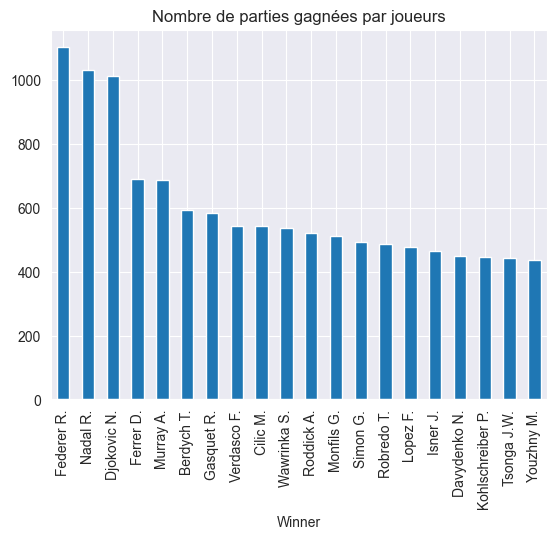

In [387]:
# Victoires par Joueur sorted
df.Winner.value_counts().nlargest(20).plot(kind='bar',title="Nombre de parties gagnées par joueurs")

<Axes: title={'center': 'Nombre de parties perdues par joueurs'}, xlabel='Loser'>

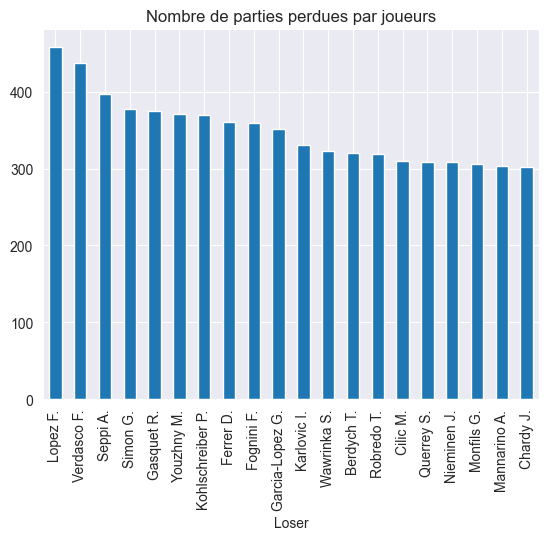

In [388]:
# Victoires par Joueur sorted
df.Loser.value_counts().nlargest(20).plot(kind='bar',title="Nombre de parties perdues par joueurs")

In [389]:
# Création du DataFrame df_player 
# player
# total play
# wins
# loses

losers = df['Loser'].unique()
winners = df['Winner'].unique()
players = np.concatenate([losers,winners])
players = np.unique(players)

players_total_play = []
players_wins = []
players_loses = []

for player in players : 
    players_total_play.append(len(df.loc[df['Winner']==player]) + len(df.loc[df['Loser']==player]))
    players_wins.append(len(df.loc[df['Winner']==player]))
    players_loses.append(len(df.loc[df['Loser']==player]))


d = {'player': players, 'games': players_total_play, 'wins':players_wins, 'loses':players_loses}
df_players = pd.DataFrame(data=d)
df_players["ratio_win"] = df_players["wins"]/df_players["games"]


<Axes: title={'center': 'Ratio victoires par parties'}, xlabel='player'>

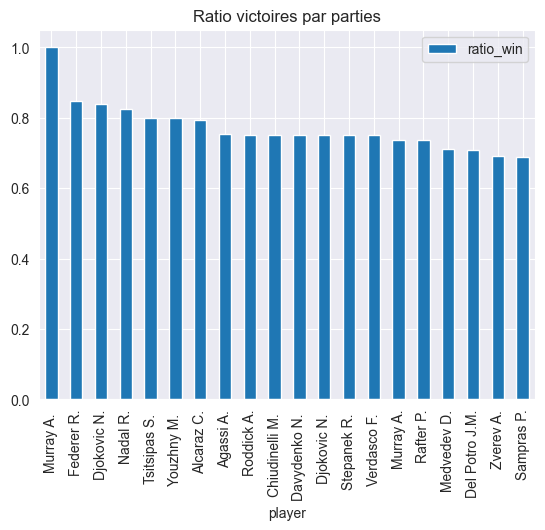

In [390]:
df_players.nlargest(20,"ratio_win").plot(kind='bar', y="ratio_win", x='player',title="Ratio victoires par parties")

In [391]:
# attention au diagramme ci-dessus, on observe que des joueurs avec peu de matchs peuvent avoir un ratio parfait
df_players.sort_values('ratio_win',ascending=False)

,player,games,wins,loses,ratio_win
990,Murray A.,5,5,0,1.000000
415,Federer R.,1299,1101,198,0.847575
347,Djokovic N.,1207,1012,195,0.838442
995,Nadal R.,1248,1031,217,0.826122
1431,Tsitsipas S.,5,4,1,0.800000
...,...,...,...,...,...
746,Krall L.,1,0,1,0.000000
745,Kralert P.,1,0,1,0.000000
1175,Riba-Madrid P.,2,0,2,0.000000
281,Cox D.,5,0,5,0.000000


In [135]:
df_players.nlargest(20,"games")

,player,games,wins,loses,ratio_win
364,Federer R.,1160,970,190,0.836207
879,Nadal R.,978,803,175,0.821063
368,Ferrer D.,957,632,325,0.660397
300,Djokovic N.,833,687,146,0.824730
108,Berdych T.,805,524,281,0.650932
1295,Verdasco F.,793,454,339,0.572509
733,Lopez F.,774,405,369,0.523256
1366,Youzhny M.,773,428,345,0.553687
261,Davydenko N.,752,453,299,0.602394
1039,Robredo T.,734,438,296,0.596730


<Axes: title={'center': 'Ratio victoires par parties pour les joueurs avec le plus grand nombre de match'}, xlabel='player'>

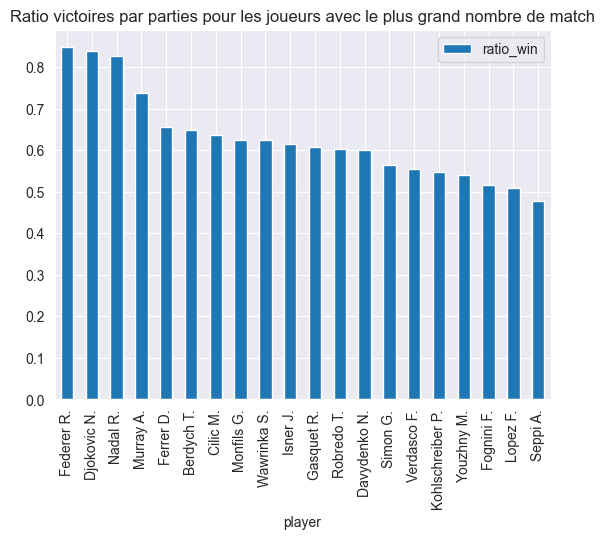

In [392]:
df_players.nlargest(20,"games").sort_values("ratio_win",ascending=False).plot(kind='bar', y="ratio_win", x='player',title="Ratio victoires par parties pour les joueurs avec le plus grand nombre de match")

influence du court (extérieur/intérieur) par joueur

In [393]:
# influence du court (extérieur/intérieur) par joueur
players_indoors_win = []
players_outdoors_win = []

for player in players : 
    winner_values = df.loc[df['Winner']==player]["Court"].value_counts()
    loser_values = df.loc[df['Loser']==player]["Court"].value_counts()

    no_indoor_loss = True
    no_outdoor_loss = True

    if hasattr(winner_values, 'Indoor'):
        indoors_win = winner_values.Indoor
    else: 
        indoors_win = 0

    if hasattr(winner_values, 'Outdoor'):
        outdoors_win = winner_values.Outdoor
    else:
        outdoors_win = 0

    if hasattr(loser_values, 'Indoor'):
        indoors_loss = loser_values.Indoor
        no_indoor_loss = False
    if hasattr(loser_values, 'Outdoor'):
        outdoors_loss = loser_values.Outdoor
        no_outdoor_loss = False

    if (no_indoor_loss):
        players_indoors_win.append(1)
    else :
        players_indoors_win.append(indoors_win / (indoors_win + indoors_loss))

    if (no_outdoor_loss):
        players_outdoors_win.append(1)
    else: 
        players_outdoors_win.append(outdoors_win / (outdoors_win + outdoors_loss))

d = {'player': players, 'games': players_total_play, 'wins':players_wins, 'loses':players_loses, 'players_outdoors_win':players_outdoors_win, 'players_indoors_win':players_indoors_win}
df_players = pd.DataFrame(data=d)


<Axes: title={'center': 'Ratio victoires par type de terrain (outdoor=1, indoor=-1) pour les 50 premiers joueurs au nombre de parties'}, xlabel='player'>

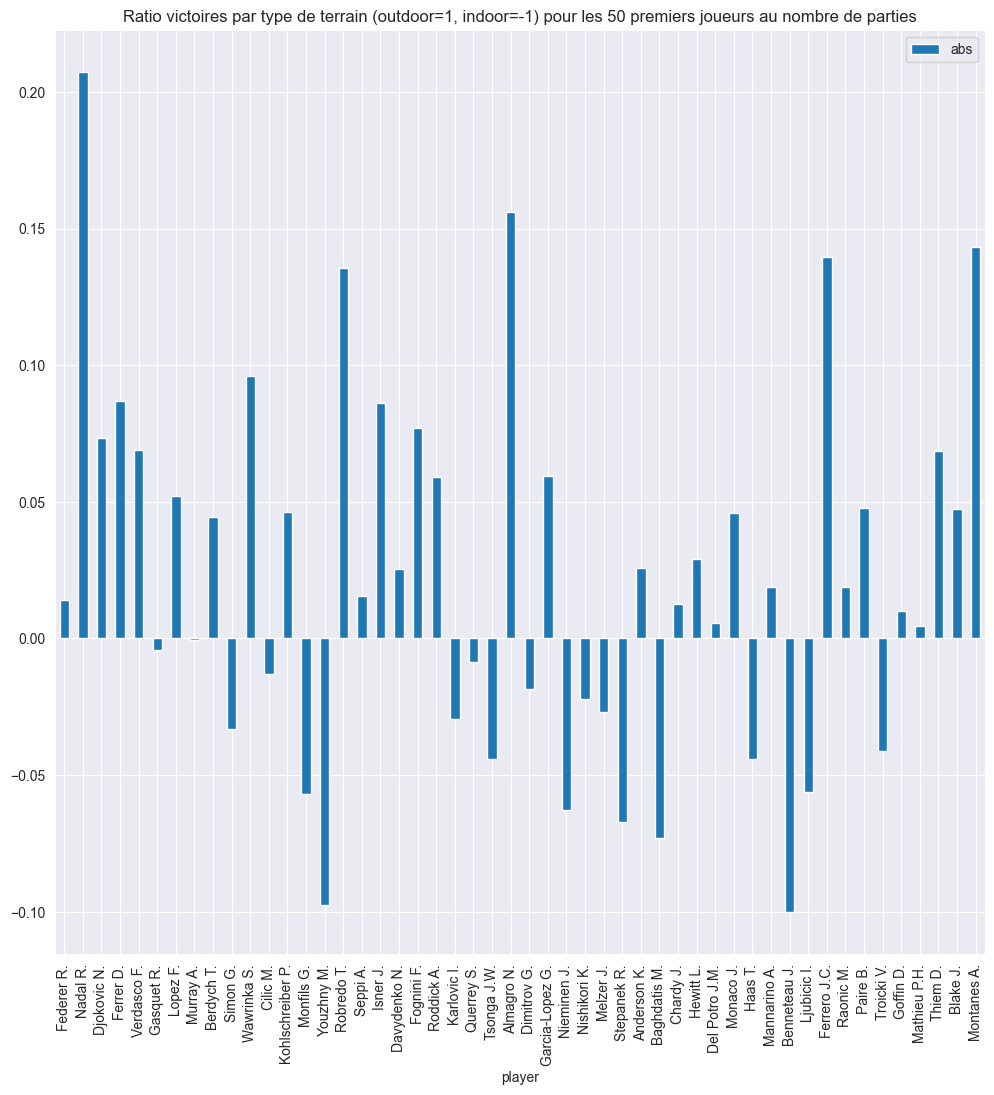

In [401]:
df_players["abs"] = (df_players["players_outdoors_win"]-df_players["players_indoors_win"])
df_players.nlargest(50,"games").plot(kind='bar', y="abs" , x='player',title="Ratio victoires par type de terrain (outdoor=1, indoor=-1) pour les 50 premiers joueurs au nombre de parties",figsize=(12,12))
#df_players.nlargest(20,"games").plot(kind='bar', y="players_indoors_win", x='player',title="Ratio victoires par parties")

On observe que l'étude de cette feature peut être pertinente pour quelques joueurs.

In [ ]:
# évolution dans le temps = constance de la performance
# influence de la surface (clay / hard / carpet or grass)
# influence de la localisation
# influence de l'age( non donné)
